In [371]:
import pandas as pd
# Setze die maximale Anzahl an Spalten, die angezeigt werden sollen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib as plt
import os

In [372]:
# Print Article Content
with open(".\\training\\12", "r", encoding="utf-8") as file:
    inhalt = file.read()
#print(inhalt)

In [373]:
def CreateFileList(files_path):
    list_of_files = []
    
    for file in os.listdir(files_path):
        list_of_files.append(file)
    
    return list_of_files

file_list_train = CreateFileList(".\\training\\")
file_list_test = CreateFileList(".\\test\\")

In [374]:
train_df = pd.read_csv("ModApte_train.csv")
test_df = pd.read_csv("ModApte_test.csv")
# remove " symbol from new_id column
train_df["new_id"] = train_df["new_id"].str.replace('"','',regex=False)
test_df["new_id"] = test_df["new_id"].str.replace('"','',regex=False)
print(train_df.shape)
# train_df.head()

(9603, 13)


In [375]:
train_df["text_type"].unique()

array(['"NORM"', '"BRIEF"', '"UNPROC"'], dtype=object)

In [376]:
# Clean out entries of csv, that are not available in original data
train_df = train_df.loc[train_df["new_id"].isin(file_list_train)]
test_df = test_df.loc[test_df["new_id"].isin(file_list_test)]
# Remove lewis_split and cgis_split
train_df = train_df.drop(columns=["lewis_split","cgis_split","old_id","people","orgs","exchanges","text_type"], axis=1)
test_df = test_df.drop(columns=["lewis_split","cgis_split","old_id","people","orgs","exchanges","text_type"], axis=1)

In [377]:
# Day Month and Year as own features
def extract_date_components(row):
    months = {
    "JAN":1,
    "FEB":2,
    "MAR":3,
    "APR":4,
    "MAY":5,
    "JUN":6,
    "JUL":7,
    "AUG":8,
    "SEP":9,
    "OCT":10,
    "NOV":11,
    "DEC":12
    }
    date_parts = row['date'].split("-")

    day = int(date_parts[0].strip())
    month = int(months[date_parts[1].strip()])
    year = int(date_parts[2][:4].strip())
    return pd.Series([day, month, year])

train_df[['day', 'month', 'year']] = train_df.apply(extract_date_components, axis=1)
test_df[['day', 'month', 'year']] = test_df.apply(extract_date_components, axis=1)
# Remove original Date column
train_df = train_df.drop(columns=["date"], axis=1)
test_df = test_df.drop(columns=["date"], axis=1)

In [378]:
def only_relevant_topics(df, min_count=50):
    # Findet die Spalten, die in weniger als `min_count` Zeilen eine 1 enthalten
    rare_columns = [col for col in df.columns if df[col].sum() < min_count]
    
    # Entfernt die seltenen Spalten aus dem DataFrame
    df = df.drop(columns=rare_columns)
    
    return df

def one_hot_encode_topics(df):
    # Entfernt überflüssige Zeichen und trennt die einzelnen Topics
    df["topics"] = df["topics"].str.replace(r"[\[\]']", "", regex=True).str.split(" ")
    
    # Entfernt leere Strings, falls diese durch das Splitten entstehen
    df["topics"] = df["topics"].apply(lambda x: [topic for topic in x if topic])
    
    # Wendet One-Hot-Encoding an
    topics_dummies = df["topics"].str.join('|').str.get_dummies()
    topics_list = topics_dummies.columns.tolist()
    
    # Ruft die Hilfsfunktion auf, um seltene Topics zu filtern
    topics_dummies = only_relevant_topics(topics_dummies, min_count=50)
    topics_list = topics_dummies.columns.tolist()

    # Verbindet die One-Hot-Spalten mit dem ursprünglichen DataFrame
    df = pd.concat([df, topics_dummies], axis=1)
    df = df.drop(columns=["topics"], axis=1)

    # Entfernt alle Zeilen, in denen alle Topics-Spalten 0 sind
    topic_rows = df[topics_list].sum(axis=1) > 0
    df = df[topic_rows]

    return df, topics_list

# Anwenden auf den DataFrame `train_df`
train_df, train_topics_list = one_hot_encode_topics(train_df)
test_df, test_topics_list = one_hot_encode_topics(test_df)

In [379]:
len(train_topics_list)

25

In [380]:
# value counts for each topic in train_df
train_df[train_topics_list].sum().sort_values(ascending=False)

earn            2877
acq             1650
money-fx         538
grain            433
crude            389
trade            368
interest         347
wheat            212
ship             197
corn             181
money-supply     140
dlr              131
sugar            126
oilseed          123
coffee           111
gnp              101
gold              94
veg-oil           86
soybean           78
bop               75
livestock         75
nat-gas           75
cpi               69
reserves          55
cocoa             55
dtype: int64

In [381]:
len(test_topics_list)

10

In [382]:
train_df.shape

(7340, 32)

In [383]:
def places_encoding(df):
    unique_places = []
    
    # Get all places
    for place in df["places"]:
        place_list = place.replace("'", "").replace("[", "").replace("]", "").split()
        try:
            for cur_place in place_list:
                if cur_place in unique_places:
                    continue
                else:
                    unique_places.append(cur_place)
                    df[cur_place] = 0
        except:
            continue

    return df

def apply_one_hot_places(row):
    # Greifen Sie auf den gesamten String in row["places"] zu, ohne [0]
    places = row["places"].replace("'", "").replace("[", "").replace("]", "").split()
    
    # Setzen Sie die One-Hot-Encoded-Werte
    for place in places:
        if place in row:
            row[place] = 1
    return row

train_df = places_encoding(train_df)
train_df = train_df.apply(apply_one_hot_places, axis=1)
test_df = places_encoding(test_df)
test_df = test_df.apply(apply_one_hot_places, axis=1)


C:\Users\tyron\AppData\Local\Temp\ipykernel_18792\554344239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cur_place] = 0
C:\Users\tyron\AppData\Local\Temp\ipykernel_18792\554344239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cur_place] = 0
C:\Users\tyron\AppData\Local\Temp\ipykernel_18792\554344239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

In [384]:
train_df.head()

,text,new_id,places,title,day,month,year,acq,bop,cocoa,coffee,corn,cpi,crude,dlr,earn,gnp,gold,grain,interest,livestock,money-fx,money-supply,nat-gas,oilseed,reserves,ship,soybean,sugar,trade,veg-oil,wheat,el-salvador,usa,uruguay,argentina,yemen-arab-republic,canada,uk,brazil,new-zealand,panama,honduras,philippines,china,algeria,switzerland,ussr,france,japan,australia,thailand,colombia,italy,indonesia,kuwait,ecuador,bahrain,saudi-arabia,qatar,oman,uae,egypt,zambia,india,netherlands,hong-kong,sweden,south-africa,south-korea,taiwan,pakistan,bangladesh,bhutan,nepal,yemen-demo-republic,iran,iraq,spain,austria,liechtenstein,west-germany,cuba,syria,portugal,greece,turkey,malaysia,mexico,zimbabwe,ireland,kenya,poland,czechoslovakia,romania,yugoslavia,belgium,chile,denmark,peru,morocco,dominican-republic,guatemala,costa-rica,israel,ivory-coast,luxembourg,papua-new-guinea,nigeria,singapore,finland,gabon,libya,venezuela,sri-lanka,jordan,east-germany,jamaica,ghana,nicaragua,paraguay,uganda,hungary,bolivia,kampuchea,sudan,burma,haiti,aruba,tanzania,norway,cyprus,madagascar,ethiopia,tunisia,iceland,trinidad-tobago,north-korea,bermuda,zaire,vietnam,liberia,cameroon,togo,lebanon,mauritius,mauritania,malawi,mozambique,vanuatu,bulgaria,malta
0,Showers continued throughout the week in\r\nth...,1,['el-salvador' 'usa' 'uruguay'],BAHIA COCOA REVIEW,26,2,1987,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The U.S. Agriculture Department\r\nreported th...,5,['usa'],NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,26,2,1987,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Argentine grain board figures show\r\ncrop reg...,6,['argentina'],ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,26,2,1987,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Champion Products Inc said its\r\nboard of dir...,9,['usa'],CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,26,2,1987,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Computer Terminal Systems Inc said\r\nit has c...,10,['usa'],COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,26,2,1987,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [385]:
train_df.isnull().sum()
# Remove all entries, where text or title is null
train_df = train_df.dropna(subset=['text', 'title'])
test_df = test_df.dropna(subset=['text', 'title'])

In [386]:
for col in train_df.columns:
    if train_df[col].dtype == "object":
        print(col)

text
new_id
places
title


In [387]:
# ID Liste erstellen
train_ids = train_df["new_id"]
test_ids = test_df["new_id"]
train_df = train_df.drop(columns=["new_id","places"], axis=1)
test_df = test_df.drop(columns=["new_id","places"], axis=1)

In [388]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in train_df.columns:
    if train_df[col].dtype == "object" and col!="text" and col!="title":
        # Initialisiere den LabelEncoder
        le = LabelEncoder()
        # Fitte und transformiere die Spalte
        train_df[col] = le.fit_transform(train_df[col])
        # Speichere den LabelEncoder für die Spalte
        label_encoders[col] = le

In [389]:
train_df.head()

,text,title,day,month,year,acq,bop,cocoa,coffee,corn,cpi,crude,dlr,earn,gnp,gold,grain,interest,livestock,money-fx,money-supply,nat-gas,oilseed,reserves,ship,soybean,sugar,trade,veg-oil,wheat,el-salvador,usa,uruguay,argentina,yemen-arab-republic,canada,uk,brazil,new-zealand,panama,honduras,philippines,china,algeria,switzerland,ussr,france,japan,australia,thailand,colombia,italy,indonesia,kuwait,ecuador,bahrain,saudi-arabia,qatar,oman,uae,egypt,zambia,india,netherlands,hong-kong,sweden,south-africa,south-korea,taiwan,pakistan,bangladesh,bhutan,nepal,yemen-demo-republic,iran,iraq,spain,austria,liechtenstein,west-germany,cuba,syria,portugal,greece,turkey,malaysia,mexico,zimbabwe,ireland,kenya,poland,czechoslovakia,romania,yugoslavia,belgium,chile,denmark,peru,morocco,dominican-republic,guatemala,costa-rica,israel,ivory-coast,luxembourg,papua-new-guinea,nigeria,singapore,finland,gabon,libya,venezuela,sri-lanka,jordan,east-germany,jamaica,ghana,nicaragua,paraguay,uganda,hungary,bolivia,kampuchea,sudan,burma,haiti,aruba,tanzania,norway,cyprus,madagascar,ethiopia,tunisia,iceland,trinidad-tobago,north-korea,bermuda,zaire,vietnam,liberia,cameroon,togo,lebanon,mauritius,mauritania,malawi,mozambique,vanuatu,bulgaria,malta
0,Showers continued throughout the week in\r\nth...,BAHIA COCOA REVIEW,26,2,1987,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The U.S. Agriculture Department\r\nreported th...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,26,2,1987,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Argentine grain board figures show\r\ncrop reg...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,26,2,1987,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Champion Products Inc said its\r\nboard of dir...,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,26,2,1987,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Computer Terminal Systems Inc said\r\nit has c...,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,26,2,1987,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [390]:
train_df_test = train_df[:1500]

In [391]:
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

def get_embeddings_batch(texts, batch_size=8):
    # Liste zur Speicherung der Embeddings
    all_embeddings = []

    # Erstelle einen DataLoader für die Batch-Verarbeitung
    text_loader = DataLoader(texts, batch_size=batch_size)

    for batch in text_loader:
        # Tokenisiere und kodiere den Batch von Texten
        encoded_input = tokenizer(
            batch,
            max_length=512,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Berechne die Embeddings mit dem BERT-Modell
        with torch.no_grad():
            outputs = model(**encoded_input)

        # Extrahiere die Embeddings und füge sie zur Liste hinzu
        embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(embeddings)

    # Kombiniere alle Embeddings zu einem Tensor
    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings

text_embeddings = get_embeddings_batch(train_df["text"].tolist())
title_embeddings = get_embeddings_batch(train_df["title"].tolist())

In [419]:
torch.save(text_embeddings, "text_embeddings.pt")
torch.save(title_embeddings, "title_embeddings.pt")

In [421]:
# shape of embeddings
text_embeddings.shape

torch.Size([6666, 768])

In [393]:
# Create List of all Col Names where dtype is numerical
numerical_columns = [col for col in train_df.columns if train_df[col].dtype != "object"]

In [394]:
numerical_columns# Kombinieren von Text- und Titel-Embeddings mit den numerischen Features
numerical_features = torch.tensor(train_df[numerical_columns].values, dtype=torch.float32)
input_features = torch.cat([text_embeddings, title_embeddings, numerical_features], dim=1)


In [395]:
numerical_features.shape

torch.Size([6666, 148])

In [396]:
input_features.shape

torch.Size([6666, 1684])

In [397]:
import torch.nn as nn

class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)  # BatchNorm für die erste Schicht
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)  # BatchNorm für die zweite Schicht
        self.fc3 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()  # Sigmoid für Multi-Label-Ausgabe
    
    def forward(self, x):
        # Erster Fully-Connected Layer + BatchNorm + ReLU + Dropout
        x = self.fc1(x)
        x = self.bn1(x)  # Batch Normalization anwenden
        x = self.relu(x)
        x = self.dropout(x)
        
        # Zweiter Fully-Connected Layer + BatchNorm + ReLU + Dropout
        x = self.fc2(x)
        x = self.bn2(x)  # Batch Normalization anwenden
        x = self.relu(x)
        x = self.dropout(x)
        
        # Letzter Fully-Connected Layer + Sigmoid
        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid für die Ausgabe
        return x


Epoch [100/2000], Loss: 1.2968, F1 Score: 0.1715
Epoch [200/2000], Loss: 1.2519, F1 Score: 0.2094
Epoch [300/2000], Loss: 1.2224, F1 Score: 0.2364
Epoch [400/2000], Loss: 1.1997, F1 Score: 0.2627
Epoch [500/2000], Loss: 1.1814, F1 Score: 0.2881
Epoch [600/2000], Loss: 1.1649, F1 Score: 0.3126
Epoch [700/2000], Loss: 1.1507, F1 Score: 0.3412
Epoch [800/2000], Loss: 1.1375, F1 Score: 0.3682
Epoch [900/2000], Loss: 1.1260, F1 Score: 0.3984
Epoch [1000/2000], Loss: 1.1146, F1 Score: 0.4241
Epoch [1100/2000], Loss: 1.1041, F1 Score: 0.4562
Epoch [1200/2000], Loss: 1.0950, F1 Score: 0.4838
Epoch [1300/2000], Loss: 1.0862, F1 Score: 0.5137
Epoch [1400/2000], Loss: 1.0779, F1 Score: 0.5410
Epoch [1500/2000], Loss: 1.0700, F1 Score: 0.5707
Epoch [1600/2000], Loss: 1.0634, F1 Score: 0.5999
Epoch [1700/2000], Loss: 1.0571, F1 Score: 0.6328
Epoch [1800/2000], Loss: 1.0509, F1 Score: 0.6636
Epoch [1900/2000], Loss: 1.0454, F1 Score: 0.6912
Epoch [2000/2000], Loss: 1.0404, F1 Score: 0.7195


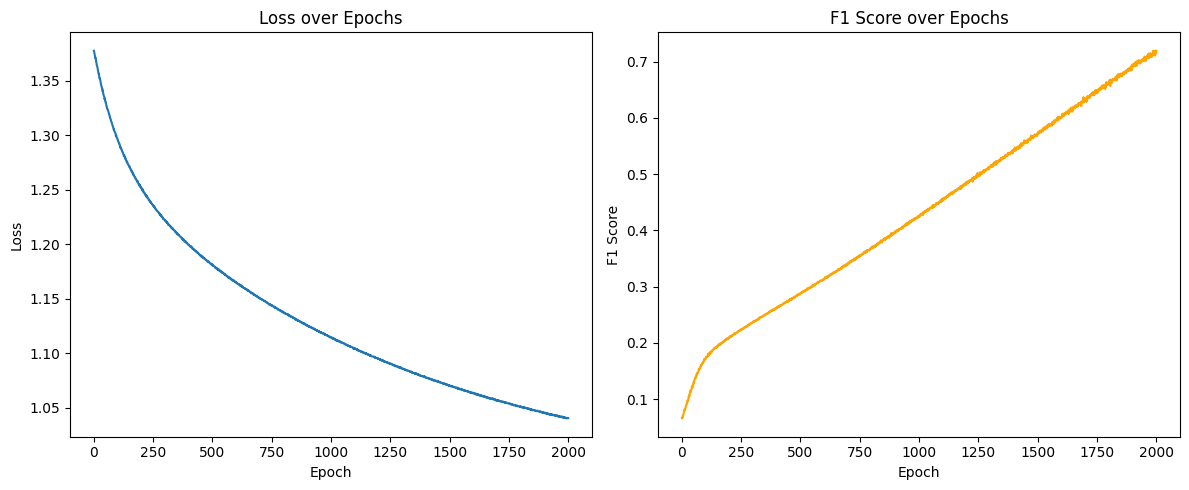

In [401]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Beispiel-Setup für das Training
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MultiLabelClassifier(input_dim=input_features.shape[1], num_classes=len(train_topics_list))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Berechne die Gewichtung für jede Klasse basierend auf der Häufigkeit
class_counts = train_df[train_topics_list].sum(axis=0)
total_counts = len(train_df)
pos_weight = (total_counts - class_counts) / class_counts

# Verwende pos_weight im Loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight.values, dtype=torch.float32))
# Listen zum Speichern der Loss- und F1-Werte pro Epoche
loss_values = []
f1_scores = []

num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    
    # Forward Pass
    outputs = model(input_features)
    loss = criterion(outputs, torch.tensor(train_df[train_topics_list].values, dtype=torch.float32))
    
    # Backward Pass and Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Speichere den Loss-Wert für die aktuelle Epoche
    loss_values.append(loss.item())
    
    # Berechne F1-Score basierend auf den Vorhersagen und den tatsächlichen Labels
    predicted_labels = (outputs > 0.5).float().cpu().numpy()  # Schwelle bei 0.5 (anpassbar)
    true_labels = train_df[train_topics_list].values
    f1 = f1_score(true_labels, predicted_labels, average='macro')  # Macro-F1-Score für Multi-Label
    f1_scores.append(f1)
    
    # Optional: nur alle 100 Epochen den Loss und F1 drucken
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, F1 Score: {f1:.4f}')

# Plot Loss und F1-Score über die Epochen
plt.figure(figsize=(12, 5))

# Loss-Verlauf plotten
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")

# F1-Score-Verlauf plotten
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), f1_scores, label="F1 Score", color='orange')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs")

plt.tight_layout()
plt.show()


In [ ]:
# compare predicted labels to actual labels in train_df_test

model.eval()
with torch.no_grad():
    predictions = model(input_features)
    predicted_labels = (predictions > 0.5).float()
    print(f1_score(train_df[train_topics_list].values, predicted_labels.numpy(), average='micro'))


0.8321159925869399
